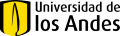

***
# **Microproyecto 1**

## Descripción del problema:

El problema a resolver consiste en generar nuevas secuencias de notas musicales basadas en el estilo de los artistas existentes, mencionados en la rúbrica del taller haciendo uso de archivos .mid como fuente de datos esto con el fin de entrenar un modelo que sea capaz de aprender de las diferentes características y posteriormente producir nuevas composiciones donde mantenga coherencia musical.

## Objetivo:

Con esta actividad se busca que el estudiante pueda poner en práctica el uso de modelos de redes neuronales para trabajar con datos secuenciales. Tras realizar esta actividad se espera que el estudiante esté en capacidad de:
1. Estructurar datos secuenciales de forma que pueden ser usados por modelos de redes neuronales.
2. Desarrollar soluciones de machine learning para datos secuenciales en distintos dominios.
3. Entrenar modelos de machine learning con múltiples salidas.
4. Entrenar modelos de machine learning con una función de costo compuesta.
5. Utilizar el modelo entrenado para generar nuevas secuencias.

***
## Integrantes Equipo 20
- Andrés Felipe Ñungo Fernández
- Andrés Julián Gonzalez Barrera
- Hernando Jose Jimenez Díaz
- Gloria Inés López Urbano

***
# Índice

El *notebook* aborda el microproyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️.   | Instalación e importe de librerías |
| 1️.1️  | Importar librerías |
| 1️.2️. | Definición variables globales |
| 2️.   | Carga y procesamiento de los datos       |
| 2️.1️. | Extracción características de los archivos .mid       |
| 2️.2️. | Estandarizar variables cuantitativas       |
| 2️.3️. | Generar secuencias de entrenamiento _requeridas para LSTM_       |
| 2️.4️. | Función Guardar secuencias a MIDI       |
| 3️. | **Definición de *pipelines* de procesamiento y modelamiento**          |
| 3️.1️. | **Definición de funciones y grillas**   |
| 4️. | **Desarrollo del modelo**   |
| 4️.1️. | **Búsqueda de hiperparámetros**   |
| 4️.2️. | **Funciones para re-entrenamiento**   |
| 4️.3️. | **Definición de _main_**   |
| 5️. | **Análisis de resultados y discusión**   |
| 6️. | **Conclusión**   |
| 7️. | **Referencias**   |

# Instalación e importe de librerías

Versión usada de Python.

In [2]:
#!python --version

Para la ejecución de este Notebook, se recomienda realizar instalación de las librerías mencionadas a continuación:

In [3]:
#!pip install torch
#!pip install pretty_midi
#!pip install mido
#!pip install pyFluidSynth

Cargar DLLs externas.
TODO: explicar como se realiza la instalacion de FluidSynth en windows

In [1]:
# Bootstrap FluidSynth 
import os
if os.name == "nt" and hasattr(os, "add_dll_directory"):
    candidates = [
        r"C:\msys64\mingw64\bin",
        r"C:\Program Files\FluidSynth\bin",
        r"C:\Tools\FluidSynth\bin",
    ]
    for dll_dir in candidates:
        if os.path.exists(dll_dir):
            os.add_dll_directory(dll_dir)
            os.environ.setdefault("FLUIDSYNTH_LIBRARY", os.path.join(dll_dir, "libfluidsynth-3.dll"))
            break

# Smoke test de la DLL para fallar pronto si algo cambió
from ctypes import CDLL
CDLL(os.environ["FLUIDSYNTH_LIBRARY"])

<CDLL 'C:\msys64\mingw64\bin\libfluidsynth-3.dll', handle 7ff938490000 at 0x1f263ed1c10>

## 1.1 Importar librerías

In [2]:
# Importación de librerías del sistema
import sys, glob
import numpy as np
import random
import warnings
from importlib.metadata import version

# Gestión de archivos
from scipy.io.wavfile import write
from pathlib import Path

# Importación de librería de DL
import torch
import torch.nn as nn
from torch.optim import AdamW
import torch.nn.functional as F


# Dataloader
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Separación de datos
from sklearn.model_selection import train_test_split

# Librerías para MIDI y audio
import fluidsynth as pyfluidsynth
import pretty_midi

In [3]:
# Ignorar las warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
librerias = ["numpy",
            "pandas",
            "scikit-learn",
            "matplotlib",
            "joblib"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  1.26.4
pandas :  2.3.2
scikit-learn :  1.7.2
matplotlib :  3.10.6
joblib :  1.5.1


## 1.2 Definición variables globales

In [4]:
#Rutas
ROOT_DIR =  "./Dataset/music_artist"  # "/content/drive/MyDrive/Colab Notebooks/Dataset/TEST"  Carpetas de compositores
OUTPUT_DIR = Path("./OUTPUT")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SF2 = "./soundfonts/FluidR3_GM.sf2"  # Ruta soundfont

# Parámetros de lotes de entrenmaiento
SEQ_LEN = 32 # Block size
BATCH_SIZE = 64
EPOCHS = 40
LR = 3e-4
PESO_LOSS_CONT = 25

# Párametros redes
HIDDEN_SIZE = 384
NUM_LAYERS = 4
DROPOUT = 0.3
PATIENCE = 10
MIN_DELTA = 1e-3

MODEL_TYPE = "LSTM"  # opciones: "RNN", "LSTM", "GRU"
INSTRUMENT_NAME = "Acoustic Grand Piano"
COMPOSER = "schubert"  # este es el artista que tiene más datos

# Parámetros de generación de secuencias
NUM_SEQS       = 3  # Número de secuencias a generar
STEPS_PER_SEQ  = 200  # Notas que debe tener cada secuencia
TEMPERATURE    = 0.6  # Temperatura
TOP_K = 10  # Metodología para delimitar el dominio de notas a elegir

## 1.2 Definición de semillas

In [5]:
RANDOM_STATE = 13
random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE); torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# 2. Carga y procesamiento de los datos.

## 2.1. Extracción características de los archivos .mid

En esta sección se realiza la selección del primer instrumento encontrado y extracción notas del instrumento seleccionado. Como resultado se extraen las siguientes características por cada nota leída:   
- Pitch: representa la nota musical.
- Step: es el espacio de tiempo que hay entre la nota anterior y la nota actual.
- Duraction: Es la diferencia de tiempo en el que termina la nota actual (end) menos el inicio de la nota (start).
- Velocity: es la velocidad de la nota musical.

In [7]:
def extract_raw_note_sequences(root_dir, instrument_name=None, program_number=None, composer_name=None):
    raw_sequences = []
    candidates = [composer_name] if composer_name else [ d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for composer in candidates:
        folder = os.path.join(root_dir, composer)
        midi_files = glob.glob(os.path.join(folder, "*.mid"))

        for mf in midi_files:
            try:
                pm = pretty_midi.PrettyMIDI(mf)
            except Exception as e:
                print(f"No se pudo leer {mf}: {e}")
                continue

            # Selección instrumento
            chosen_instruments = []
            for i, inst in enumerate(pm.instruments):
                name = pretty_midi.program_to_instrument_name(inst.program)
                print(f"[{i}] prog={inst.program:>2} name={name} notas={len(inst.notes)}")
                if instrument_name is not None:
                    inst_name = pretty_midi.program_to_instrument_name(inst.program)
                    if inst_name.lower() == instrument_name.lower():
                        chosen_instruments.append(inst)
                elif program_number is not None:
                    if inst.program == program_number:
                        chosen_instruments.append(inst)

            # Si no hubo match explícito y no se especificó filtro, tomamos el primero (comportamiento viejo)
            if instrument_name is None and program_number is None:
                chosen_instruments = pm.instruments[:1]  

            if not chosen_instruments:
                # Nada que extraer en este archivo para el instrumento pedido
                continue

            # Extraer notas SOLO del/los instrumentos elegidos 
            notes = []
            for inst in chosen_instruments:
                for note_mus in inst.notes:
                    start = note_mus.start
                    end = note_mus.end
                    duration = end - start
                    velocity = note_mus.velocity
                    notes.append((start, note_mus.pitch, duration, velocity))

            if not notes:
                continue

            # Ordenar por inicio y construir [pitch, step, duration, velocity]
            notes.sort(key=lambda x: x[0])
            note_feats = []
            prev_start = notes[0][0]
            for start, pitch, duration, velocity in notes:
                step = start - prev_start
                prev_start = start
                note_feats.append([pitch, step, duration, velocity])

            if note_feats:
                raw_sequences.append(np.array(note_feats, dtype=np.float32))

    return raw_sequences

## 2.2. Estandarizar variables cuantitativas

Este paso es necesario dado que los modelos de red neuronal son muy sensibles a las escalas de los datos. Al no estandarizar las variables continuas, el modelo no aprenderá correctamente las relaciones entre variables.
La presente estandarización lleva todas las variables continuas a extraer el promedio y la desviación estandar normalizando cada valor individual, siguiendo la fórmula del z-score:
`norm_x = (x - mean) / std`.

In [8]:
def standardize_note_sequences(sequences):
    """
    Estandariza las variables continuas (step, duration, velocity)
    y mantiene el pitch intacto para usarlo luego con embeddings.
    """
    all_steps, all_durations, all_velocities = [], [], []

    # Recolectar todas las variables continuas para calcular media y std global
    for seq in sequences:
        all_steps.extend(seq[:, 1])
        all_durations.extend(seq[:, 2])
        all_velocities.extend(seq[:, 3])

    # Estadísticas globales
    step_mean, step_std = np.mean(all_steps), np.std(all_steps)
    dur_mean, dur_std = np.mean(all_durations), np.std(all_durations)
    vel_mean, vel_std = np.mean(all_velocities), np.std(all_velocities)

    standardized = []
    for seq in sequences:
        seq_std = seq.copy()
        # No tocar pitch (columna 0)
        seq_std[:, 1] = (seq[:, 1] - step_mean) / (step_std + 1e-6)
        seq_std[:, 2] = (seq[:, 2] - dur_mean) / (dur_std + 1e-6)
        seq_std[:, 3] = (seq[:, 3] - vel_mean) / (vel_std + 1e-6)
        standardized.append(seq_std)

    stats = {"step_mean": step_mean, "step_std": step_std,
            "dur_mean": dur_mean, "dur_std": dur_std,
            "vel_mean": vel_mean, "vel_std": vel_std}

    return standardized, stats

## 2.3. Generar secuencias de entrenamiento

Esta sección realiza la conversión de una secuencia larga de notas en muestras pequeñas de longitud fija llamadas ventanas o secuencias de entrenamiento.
La entrada de datos debe tener estandarizadas las variables continuas.

In [9]:
def create_windows(sequences, seq_len=32):
    """
    Crea pares (X, y) para entrenamiento a partir de las secuencias estandarizadas.
    X: secuencia de longitud seq_len
    y: la nota siguiente
    La variable pitch se mantiene intacto dado que es una variable categórica que se usará con embeddings.
    """
    X_pitch, X_cont, y_pitch, y_cont = [], [], [], []

    for seq in sequences:
        if len(seq) < seq_len + 1:
            continue

        # Dividir en ventanas
        for i in range(len(seq) - seq_len):
            window = seq[i:i+seq_len]
            target = seq[i+seq_len]

            # Separar pitch (entero) y las features continuas
            X_pitch.append(window[:, 0].astype(np.int64))     # pitch
            X_cont.append(window[:, 1:].astype(np.float32))   # step, duration, velocity
            y_pitch.append(int(target[0]))                    # pitch de la siguiente nota
            y_cont.append(target[1:].astype(np.float32))      # step, duration, velocity siguientes

    # Convertir a arrays numpy
    X_pitch = np.array(X_pitch, dtype=np.int64)
    X_cont = np.array(X_cont, dtype=np.float32)
    y_pitch = np.array(y_pitch, dtype=np.int64)
    y_cont = np.array(y_cont, dtype=np.float32)

    return (X_pitch, X_cont), (y_pitch, y_cont)

## 2.4. Función Guardar secuencias a MIDI

La función `save_sequence_to_midi` permite tomar las secuencias estandarizadas y generar de nuevo el archivo .mid con el fin de validar que no se haya corrompido las notas musicales.

In [10]:
def save_sequence_to_midi(seq, output_path="generated.mid", instrument_name="Acoustic Grand Piano"):
    """
    seq: np.array (N,4) con columnas [pitch, step, duration, velocity] en ESCALA REAL.
    """
    pm = pretty_midi.PrettyMIDI()
    try:
        program_number = pretty_midi.instrument_name_to_program(instrument_name)
    except ValueError:
        program_number = 0
    instrument = pretty_midi.Instrument(program=program_number)

    # Asegurar valores válidos
    pitch    = seq[:, 0].astype(int)
    step     = np.maximum(seq[:, 1].astype(float), 0.0)
    duration = np.maximum(seq[:, 2].astype(float), 0.01)
    velocity = np.clip(seq[:, 3].astype(float), 0, 127).astype(int)

    # Reconstruir tiempos absolutos
    t = 0.0
    for p, s, d, v in zip(pitch, step, duration, velocity):
        t += s
        note = pretty_midi.Note(velocity=int(v), pitch=int(p), start=float(t), end=float(t + d))
        instrument.notes.append(note)

    pm.instruments.append(instrument)
    pm.write(output_path)
    print(f"MIDI guardado en: {output_path} ({instrument_name})")


In [11]:
def save_std_sequence_to_midi(seq_std, stats, output_path="reconstructed.mid", instrument_name="Acoustic Grand Piano"):
    """
    seq_std: np.array (N,4) [pitch, stepZ, durationZ, velocityZ] estandarizados.
    stats: dict con medias/stds {'step_mean','step_std','dur_mean','dur_std','vel_mean','vel_std'}
    """
    import numpy as np
    # Desestandarizar
    pitch    = seq_std[:, 0]
    step     = seq_std[:, 1] * stats["step_std"] + stats["step_mean"]
    duration = seq_std[:, 2] * stats["dur_std"] + stats["dur_mean"]
    velocity = seq_std[:, 3] * stats["vel_std"] + stats["vel_mean"]
    seq_real = np.stack([pitch, step, duration, velocity], axis=1)
    # Reutilizar la canónica
    save_sequence_to_midi(seq_real, output_path=output_path, instrument_name=instrument_name)


## Pasar de MIDI a WAV

In [12]:
def render_midi_to_wav(midi_path: str, wav_path: str, sf2_path: str, samplerate: int = 44100):

    fs = pyfluidsynth.Synth(samplerate=samplerate)
    try:
        fs.start(driver="dsound" if os.name == "nt" else "alsa")
    except Exception:
        fs.start()  # fallback genérico

    sfid = fs.sfload(sf2_path)
    fs.program_select(0, sfid, 0, 0)

    pm = pretty_midi.PrettyMIDI(midi_path)

    # Renderizamos manualmente los eventos del track 0
    # (PrettyMIDI puede reproducir directo, pero aquí controlamos la cadena)
    audio = pm.fluidsynth(fs=samplerate, sf2_path=sf2_path)  # interfaz estable
    # Normalización suave y a PCM16
    peak = float(np.max(np.abs(audio))) if audio.size else 1.0
    audio = (audio / (peak if peak > 0 else 1.0)) * 0.99
    audio_int16 = (np.clip(audio, -1, 1) * 32767).astype(np.int16)
    write(wav_path, samplerate, audio_int16)
    fs.delete()

#  Dataset pytorch

In [13]:
class MusicWindowsDataset(Dataset):
    def __init__(self, Xp, Xc, yp, yc):
        self.Xp = Xp
        self.Xc = Xc
        self.yp = yp
        self.yc = yc

    def __len__(self):
        return len(self.Xp)

    def __getitem__(self, i):
        import torch
        Xp = torch.as_tensor(self.Xp[i], dtype=torch.long)        # [L]
        Xc = torch.as_tensor(self.Xc[i], dtype=torch.float32)     # [L,3]
        yp = torch.as_tensor(self.yp[i], dtype=torch.long)        # []
        yc = torch.as_tensor(self.yc[i], dtype=torch.float32)     # [3]
        return (Xp, Xc), (yp, yc)  

# Test modelo

In [14]:
class MusicLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, cont_dim=3, hidden_size=256, num_layers=2, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=None)
        self.input_dim = emb_dim + cont_dim
        self.lstm = nn.LSTM(self.input_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.pitch_out = nn.Linear(hidden_size, vocab_size)  # clasificación pitch
        self.cont_out = nn.Linear(hidden_size, cont_dim)     # regresión step,duration,velocity

    def forward(self, pitch_seq, cont_seq):
        """
        pitch_seq: LongTensor (B, seq_len)
        cont_seq: FloatTensor (B, seq_len, cont_dim)
        returns:
            pitch_logits: (B, vocab_size)
            cont_pred: (B, cont_dim)
        """
        emb = self.emb(pitch_seq)                # (B, seq_len, emb_dim)
        x = torch.cat([emb, cont_seq], dim=-1)   # (B, seq_len, emb+cont)
        out, (h, c) = self.lstm(x)               # out: (B, seq_len, hidden)
        last = out[:, -1, :]                     # (B, hidden)
        pitch_logits = self.pitch_out(last)      # (B, vocab_size)
        cont_pred = self.cont_out(last)          # (B, cont_dim)
        return pitch_logits, cont_pred

# Diagrama de arquitectura

### Pendiente

# Entrenamiento

In [15]:
class EarlyStopping:
    """
    Early stopping basado en una métrica escalar (modo 'min').
    Guarda el mejor valor observado y cuenta épocas sin mejora.
    """
    def __init__(self, patience=6, min_delta=0.0):
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.best = None
        self.bad_epochs = 0

    def step(self, value: float) -> bool:
        """
        Devuelve True si hubo mejora y debe guardarse checkpoint.
        """
        if self.best is None or (value < self.best - self.min_delta):
            self.best = float(value)
            self.bad_epochs = 0
            return True
        else:
            self.bad_epochs += 1
            return False

    def should_stop(self) -> bool:
        return self.bad_epochs >= self.patience

In [16]:
def train(model,train_loader,
          val_loader,
          device,
          epochs=40,
          lr=5e-4,
          cont_loss_weight=50.0,
          # 🔹 parámetros de early stopping
          es_patience=6,
          es_min_delta=0.0,
          best_ckpt_path="OUTPUT/best_music_lstm.pth",
          verbose=True):



    model.to(device)
    opt = AdamW(model.parameters(), lr=lr)

    history = { "train_loss": [],
                "val_CE": [],
                "val_MSE": [],
                "val_total": [],
                "best_epoch": None,
                "best_val_total": None,
                "best_ckpt_path": best_ckpt_path}

    # Inicializa EarlyStopping
    es = EarlyStopping(patience=es_patience, min_delta=es_min_delta)

    for epoch in range(1, epochs + 1):
        # Entrenamiento
        model.train()
        running = 0.0
        for (Xp, Xc), (yp, yc) in train_loader:
            Xp = Xp.to(device)           
            Xc = Xc.to(device)           
            yp = yp.to(device)           
            yc = yc.to(device)         

            opt.zero_grad(set_to_none=True)
            logits, cont_pred = model(Xp, Xc)         # logits [B,L,V]; cont_pred [B,L,3]
            # Usa directamente la salida del modelo
            logits_last = logits               # (B, V)
            cont_last   = cont_pred            # (B, 3)

            ce  = F.cross_entropy(logits_last, yp)    # CE para pitch
            mse = F.mse_loss(cont_last, yc)           # MSE para continuos (normalizados)
            loss = ce + cont_loss_weight * mse

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            running += loss.item()

        train_loss = running / max(1, len(train_loader))

        # Validación
        model.eval()
        val_ce = 0.0
        val_mse = 0.0
        with torch.no_grad():
            for (Xp, Xc), (yp, yc) in val_loader:
                Xp = Xp.to(device)
                Xc = Xc.to(device)
                yp = yp.to(device)
                yc = yc.to(device)

                logits, cont_pred = model(Xp, Xc)
                logits_last = logits          # (B, V)
                cont_last   = cont_pred       # (B, 3)

                ce  = F.cross_entropy(logits_last, yp)
                mse = F.mse_loss(cont_last, yc)
                val_ce  += ce.item()
                val_mse += mse.item()

        val_ce  /= max(1, len(val_loader))
        val_mse /= max(1, len(val_loader))
       
        val_total = val_ce + cont_loss_weight * val_mse

        history["train_loss"].append(train_loss)
        history["val_CE"].append(val_ce)
        history["val_MSE"].append(val_mse)
        history["val_total"].append(val_total)

        if verbose:
            print(f"Epoch {epoch} | train_loss={train_loss:.4f} | "
                  f"val_CE={val_ce:.4f} | val_MSE={val_mse:.5f} | "
                  f"val_total={val_total:.4f}")

        # Checkpoint si mejora
        if es.step(val_total):
            torch.save({"model_state": model.state_dict()}, best_ckpt_path)
            history["best_epoch"] = epoch
            history["best_val_total"] = val_total
            if verbose:
                print(f"  ↳ ✓ Nuevo mejor modelo guardado en {best_ckpt_path}")

        # Parar si no mejora por 'patience'
        if es.should_stop():
            if verbose:
                print(f"  ↳ Early stopping en epoch {epoch} (best_epoch={history['best_epoch']})")
            break

    return history

# Generacion

In [17]:
#sample_from_logits
def sample_from_logits_topk(logits, k=10, temperature=1.0):
    """
    logits: torch.Tensor [vocab] o numpy.ndarray [vocab]
    Devuelve: índice entero muestreado en top-k (con temperatura).
    """
    import torch
    if not isinstance(logits, torch.Tensor):
        logits = torch.from_numpy(logits)

    # Evita k inválido
    vocab = logits.shape[-1]
    k = max(1, min(int(k), int(vocab)))

    # Último paso de la secuencia si viene con eje extra
    # (p.ej., [1, V] -> [V])
    if logits.ndim > 1:
        logits = logits.view(-1)

    # Temperatura
    if temperature is None or temperature <= 0:
        temperature = 1.0
    logits = logits / float(temperature)

    # Top-k + muestreo
    topk_vals, topk_idx = torch.topk(logits, k)          
    topk_probs = torch.softmax(topk_vals, dim=-1)        
    choice = torch.multinomial(topk_probs, 1)            
    return int(topk_idx[choice].item())



@torch.no_grad()
def generate_sequence(model, device,
                      seed_pitch_seq,   
                      seed_cont_seq,    
                      steps=200,
                      idx2pitch=None,
                      stats=None,
                      temperature=1.0,
                      top_k=10,
                      max_context=32):
    """
    Devuelve: np.ndarray shape [T_gen, 4] con columnas [pitch, step, dur, vel]
              (en tu mismo formato downstream).
    """
    model.eval()

    # Normalización defensiva de entradas
    seed_pitch_seq = np.asarray(seed_pitch_seq, dtype=np.int64)          
    seed_cont_seq  = np.asarray(seed_cont_seq,  dtype=np.float32)        
    assert seed_cont_seq.ndim == 2 and seed_cont_seq.shape[1] == 3, "seed_cont_seq debe ser [T,3]"

    # Construir tensores en el dispositivo sin listas de ndarrays:
    def _mk_inputs(pitches_np, cont_np):
        # recorta al contexto
        pitches_np = pitches_np[-max_context:]
        cont_np    = cont_np[-max_context:]
        inp_pitch = torch.as_tensor(pitches_np, dtype=torch.long, device=device).unsqueeze(0)   # [1, L]
        inp_cont  = torch.as_tensor(cont_np,    dtype=torch.float32, device=device).unsqueeze(0) # [1, L, 3]
        return inp_pitch, inp_cont

    # Copias de trabajo (para ir anexando)
    cur_pitch = seed_pitch_seq.copy()
    cur_cont  = seed_cont_seq.copy()

    generated_rows = []  # acumularemos filas [pitch, step, dur, vel] 

    for _ in range(steps):
        inp_pitch, inp_cont = _mk_inputs(cur_pitch, cur_cont)
        logits, cont_pred = model(inp_pitch, inp_cont)  

        # Tomar el último paso temporal
        logits_last = logits.squeeze(0)                
        cont_last   = cont_pred.squeeze(0).cpu().numpy() # (3,)  

        # Muestreo discreto
        next_pitch_idx = sample_from_logits_topk(logits_last, k=top_k, temperature=temperature)

        # Desnormalizar los 3 continuos 
        if stats is not None:
            step = (cont_last[0] * (float(stats["step_std"]) + 1e-6)) + float(stats["step_mean"])
            dur  = (cont_last[1] * (float(stats["dur_std"])  + 1e-6)) + float(stats["dur_mean"])
            vel  = (cont_last[2] * (float(stats["vel_std"])  + 1e-6)) + float(stats["vel_mean"])
        else:
            step, dur, vel = float(cont_last[0]), float(cont_last[1]), float(cont_last[2])

        # Seguridad: valores válidos
        next_pitch = int(np.clip(next_pitch_idx, 0, 127))
        step = max(0.0, float(step))
        dur  = max(1e-3, float(dur))
        vel  = float(np.clip(vel, 1.0, 127.0))

        # Append a las listas de estado (en formato NORMALIZADO para el modelo)
        # Nota: para la siguiente iteración el modelo necesita los continuos NORMALIZADOS,
        # por lo que guardamos además la versión normalizada:
        if stats is not None:
            step_n = (step - float(stats["step_mean"])) / (float(stats["step_std"]) + 1e-6)
            dur_n  = (dur  - float(stats["dur_mean"]))  / (float(stats["dur_std"])  + 1e-6)
            vel_n  = (vel  - float(stats["vel_mean"]))  / (float(stats["vel_std"])  + 1e-6)
            cur_cont = np.vstack([cur_cont, [step_n, dur_n, vel_n]]).astype(np.float32)
        else:
            cur_cont = np.vstack([cur_cont, [step, dur, vel]]).astype(np.float32)

        cur_pitch = np.append(cur_pitch, next_pitch).astype(np.int64)

        # Guardar fila desnormalizada para el MIDI
        generated_rows.append([next_pitch, step, dur, vel])

    return np.asarray(generated_rows, dtype=np.float32)


# Pipeline completo

In [18]:
if __name__ == "__main__":
    print("1) Extrayendo secuencias crudas...")
    raw_sequences = extract_raw_note_sequences(ROOT_DIR, instrument_name= INSTRUMENT_NAME, composer_name=COMPOSER)
    print(f"  secuencias extraídas: {len(raw_sequences)}")

    train_sequences, val_sequences = train_test_split(raw_sequences, test_size=0.2, random_state=RANDOM_STATE)

    print("2) Estandarizando (pitch se mantiene intacto)...")
    standardized_sequences, stats = standardize_note_sequences(train_sequences)
    print("  stats:", stats)

    def apply_standardization(seqs, stats):
        out = []
        for seq in seqs:
            s = seq.copy()
            s[:,1] = (s[:,1]-stats["step_mean"])/(stats["step_std"]+1e-6)
            s[:,2] = (s[:,2]-stats["dur_mean"] )/(stats["dur_std"] +1e-6)
            s[:,3] = (s[:,3]-stats["vel_mean"] )/(stats["vel_std"] +1e-6)
            out.append(s)
        return out

    val_standardized = apply_standardization(val_sequences, stats)
    print("3) Creando ventanas...")
    (Xp_tr, Xc_tr), (yp_tr, yc_tr) = create_windows(standardized_sequences, seq_len=SEQ_LEN)
    (Xp_va, Xc_va), (yp_va, yc_va) = create_windows(val_standardized,       seq_len=SEQ_LEN)

    print("  Train -> Xp_tr:", Xp_tr.shape, "Xc_tr:", Xc_tr.shape, "yp_tr:", yp_tr.shape)
    print("  Valid -> Xp_va:", Xp_va.shape, "Xc_va:", Xc_va.shape, "yp_va:", yp_va.shape)


    # construir vocab (opcional
    if Xp_tr.shape[0] == 0:
        raise RuntimeError("No hay muestras. Aumenta datos o reduce SEQ_LEN.")
    max_pitch = int(np.max(Xp_tr))
    vocab_size = max(128, max_pitch + 1)
    print("vocab_size:", vocab_size)

    # dataset
    train_ds = MusicWindowsDataset(Xp_tr, Xc_tr, yp_tr, yc_tr)
    val_ds   = MusicWindowsDataset(Xp_va,   Xc_va,   yp_va,   yc_va)
    loader   = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    vloader  = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    # modelo
    model = MusicLSTM(vocab_size=vocab_size, emb_dim=64, cont_dim=3, hidden_size= HIDDEN_SIZE, num_layers= NUM_LAYERS,dropout=DROPOUT) # Ajustado num_layers
    print("Training model on device:", DEVICE)
    history = train(
        model,
        train_loader=loader,
        val_loader=vloader,
        device=DEVICE,
        epochs=EPOCHS,
        lr=LR,
        cont_loss_weight= PESO_LOSS_CONT,
        es_patience= PATIENCE,                
        es_min_delta= MIN_DELTA,           
        best_ckpt_path=(OUTPUT_DIR / "best_music_lstm.pth").as_posix(),
    )

    # Guardar modelo y stats
    # Cargar mejor estado antes de generar
    best_ckpt = torch.load((OUTPUT_DIR / "best_music_lstm.pth").as_posix(), map_location=DEVICE)
    model.load_state_dict(best_ckpt["model_state"])
    model.to(DEVICE)
    model.eval()

    #  Generación de ejemplos
 
    total_samples = Xp_tr.shape[0]
   
    # Elegimos índices de semillas distintos si hay suficientes, o con reposición si no
    idx_pool = list(range(total_samples))
    if total_samples >= NUM_SEQS:
        seed_indices = random.sample(idx_pool, NUM_SEQS)  # sin reemplazo
    else:
        seed_indices = [random.choice(idx_pool) for _ in range(NUM_SEQS)]  # con reemplazo
    
    for j, idx in enumerate(seed_indices, start=1):
        seed_pitch = Xp_tr[idx].tolist()
        seed_cont  = Xc_tr[idx]
        print(f"[Gen {j}] Usando semilla index: {idx}")
    
        generated = generate_sequence(
            model, DEVICE,
            seed_pitch, seed_cont,
            steps=STEPS_PER_SEQ,
            idx2pitch=None,
            stats=stats,
            temperature=TEMPERATURE,
            top_k=TOP_K)
        
        if generated.shape[0] > 200:
          generated = generated[-200:, :]
    
        midi_path = OUTPUT_DIR / f"generated_music_lstm_{j}.mid"
        wav_path = OUTPUT_DIR / f"generated_music_lstm_{j}.wav"
        
        save_sequence_to_midi(generated, output_path=midi_path.as_posix(), instrument_name=INSTRUMENT_NAME)
        
        try:
            render_midi_to_wav(midi_path.as_posix(), wav_path.as_posix(), SF2, samplerate=44100)
            print(f"[Gen {j}] WAV guardado en:  {wav_path}")
        except Exception as e:
            print(f"[Gen {j}] No se pudo generar WAV (revisa pyfluidsynth/DLL/SF2): {e}")
        
        print(f"[Gen {j}] MIDI guardado en: {midi_path}")

1) Extrayendo secuencias crudas...
[0] prog= 0 name=Acoustic Grand Piano notas=4225
[1] prog= 0 name=Acoustic Grand Piano notas=3300
[0] prog= 0 name=Acoustic Grand Piano notas=2954
[1] prog= 0 name=Acoustic Grand Piano notas=2173
[0] prog= 0 name=Acoustic Grand Piano notas=3868
[1] prog= 0 name=Acoustic Grand Piano notas=2580
[0] prog= 0 name=Acoustic Grand Piano notas=3185
[1] prog= 0 name=Acoustic Grand Piano notas=2792
[0] prog= 0 name=Acoustic Grand Piano notas=2854
[1] prog= 0 name=Acoustic Grand Piano notas=3395
[0] prog= 0 name=Acoustic Grand Piano notas=1850
[1] prog= 0 name=Acoustic Grand Piano notas=885
[0] prog= 0 name=Acoustic Grand Piano notas=3239
[1] prog= 0 name=Acoustic Grand Piano notas=3186
[0] prog= 0 name=Acoustic Grand Piano notas=2970
[1] prog= 0 name=Acoustic Grand Piano notas=1822
[0] prog= 0 name=Acoustic Grand Piano notas=2592
[1] prog= 0 name=Acoustic Grand Piano notas=2073
[0] prog= 0 name=Acoustic Grand Piano notas=1779
[1] prog= 0 name=Acoustic Grand Pia

# Celda usada Font de los Markdowns

In [19]:
%%html
<!-- Fuentes recomendadas para estilo matemático -->
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Text:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Math:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">
<link href="https://fonts.googleapis.com/css2?family=Inconsolata:wght@400;700&display=swap" rel="stylesheet">

<style>
  /* --- Markdown clásico (Notebook) --- */
  div.text_cell_render.rendered_html p,
  div.text_cell_render.rendered_html h1,
  div.text_cell_render.rendered_html h2,
  div.text_cell_render.rendered_html h3,
  div.text_cell_render.rendered_html li {
    font-family: 'STIX Two Text', serif !important;
  }

  /* MathJax (fórmulas) */
  .MathJax, .MathJax_Display {
    font-family: 'STIX Two Math', serif !important;
  }

  /* Código */
  div.text_cell_render.rendered_html code,
  div.text_cell_render.rendered_html pre {
    font-family: 'Inconsolata', monospace !important;
  }

  /* --- JupyterLab --- */
  .jp-Notebook .jp-RenderedHTMLCommon p,
  .jp-Notebook .jp-RenderedHTMLCommon h1,
  .jp-Notebook .jp-RenderedHTMLCommon h2,
  .jp-Notebook .jp-RenderedHTMLCommon h3,
  .jp-Notebook .jp-RenderedHTMLCommon li {
    font-family: 'STIX Two Text', serif !important;
  }
  .jp-Notebook .jp-RenderedHTMLCommon code,
  .jp-Notebook .jp-RenderedHTMLCommon pre {
    font-family: 'Inconsolata', monospace !important;
  }
  .jp-Notebook .MathJax,
  .jp-Notebook .MathJax_Display {
    font-family: 'STIX Two Math', serif !important;
  }
</style>